<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/object_detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "/content/gdrive/My Drive"

In [0]:
import os 
import cv2
import numpy as np

from torchvision.datasets.voc import VOCDetection
import torchvision.transforms as transforms
import torchvision.transforms.functional as func

class MyVOCDetection(VOCDetection):

    def __init__(self, root, image_set, download=False, transforms=None):
      super(MyVOCDetection, self).__init__(root, image_set=image_set, download=download)
      self.dim = (300, 300)
      self.my_transforms = transforms

    def __getitem__(self, index):
      img, target = super().__getitem__(index)

      annotation = target["annotation"]
      boxes_dict = annotation["object"]
      if isinstance(boxes_dict, dict):
        boxes_dict = [boxes_dict]
      size = annotation["size"]
      size = (int(size["depth"]), int(size["height"]), int(size["width"]))
      
      boxes = []
      for box in boxes_dict:
          boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                        float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
      boxes = np.array(boxes)
      
      img = func.resize(img, self.dim)

      if self.my_transforms is not None:
        img = self.my_transforms(img)
      
      boxes[:, 0] = boxes[:, 0] * (self.dim[0] / float(size[2]))
      boxes[:, 1] = boxes[:, 1] * (self.dim[1] / float(size[1]))
      boxes[:, 2] = boxes[:, 2] * (self.dim[0] / float(size[2]))
      boxes[:, 3] = boxes[:, 3] * (self.dim[1] / float(size[1]))
      
      return (img, 
              size, 
              boxes)

ROOT_PATH = os.path.join(PATH, "datasets")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

tf = None 
    # transforms.Compose([
    #         transforms.ToTensor(),
    #         normalize,
    #     ])

train_dataset = MyVOCDetection(ROOT_PATH, image_set="train", download=False, transforms=tf)
val_dataset = MyVOCDetection(ROOT_PATH, image_set="val", download=False, transforms=tf)

In [0]:
BATCH_SIZE = 8

In [0]:
from torch.utils.data import DataLoader

def my_collate_fn(samples):

    images = []
    sizes = []
    boxes_batch = []

    for (img, size, boxes) in samples:
        
        images.append(img)
        boxes_batch.append(boxes)
        sizes.append(size)

    return {"img": images,
            "boxes": boxes_batch,
            "size": sizes,
            }

train_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=0, pin_memory=True, 
                        collate_fn=my_collate_fn)
val_load = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        num_workers=0, pin_memory=True)

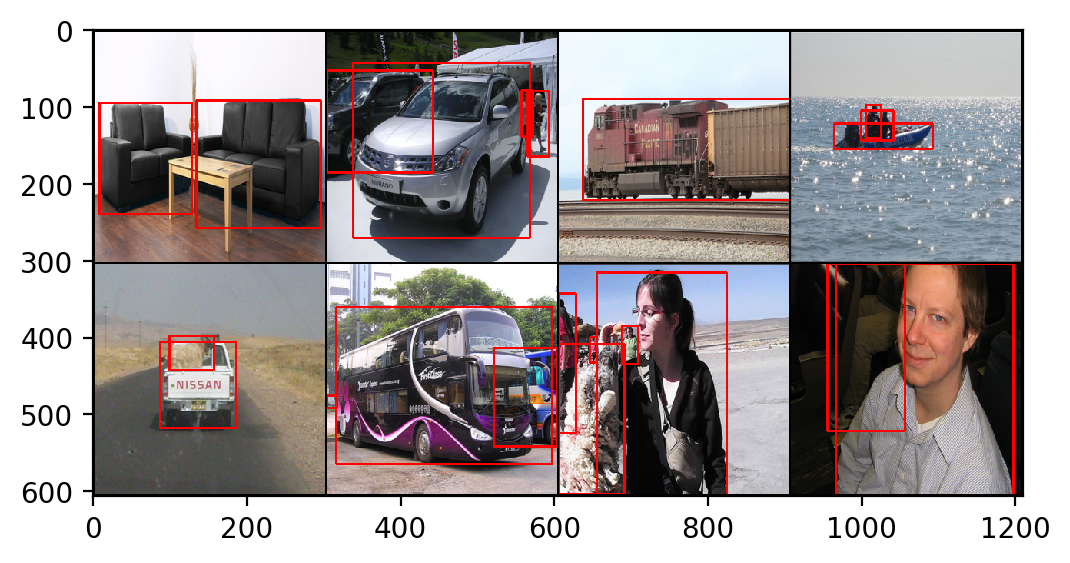

In [90]:
import torchvision.utils as utils
import torch
import matplotlib.pyplot as plt

# batch = next(iter(train_load))

def draph_boxes(image, objs):
  
    image = np.array(image)

    for box in objs:
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255,0,0), 2)

    return torch.from_numpy(np.transpose(image, (2, 0, 1)))

new_imgs = []
for i, img in enumerate(batch["img"]):
    new_imgs.append(draph_boxes(img, batch["boxes"][i]))

grid = utils.make_grid(new_imgs, 4, padding=2)
ngrid = grid.numpy()

plt.figure(dpi=200)
plt.imshow(np.transpose(ngrid, (1, 2, 0)))

In [0]:
def flip(image, boxes):

    # Flip image
    # image = func.to_pil_image(image)
    new_image = func.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

In [0]:
img = batch["img"][0]
boxes = batch["boxes"][0]

In [0]:
def draph_img(img, boxes):
    draw_img = draph_boxes(img, boxes)
    plt.imshow(np.transpose(draw_img.numpy(), (1, 2, 0)))

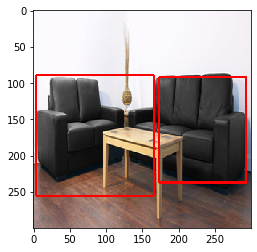

In [105]:
draph_img(img, boxes)

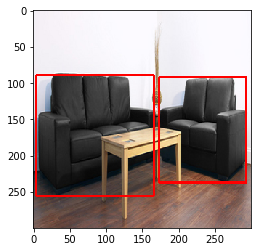

In [104]:
img_flip, boxes_flip = flip(img, boxes)

draph_img(img_flip, boxes_flip)

In [0]:
import random

def photometric_distort(image):
  
    new_image = image

    distortions = [func.adjust_brightness,
                   func.adjust_contrast,
                   func.adjust_saturation,
                   func.adjust_hue]

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':                
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:              
                adjust_factor = random.uniform(0.5, 1.5)
            
            new_image = d(new_image, adjust_factor)

    return new_image

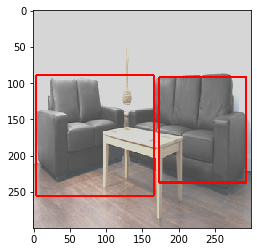

In [112]:
img_dist = photometric_distort(img)

draph_img(img_dist, boxes)

In [0]:
 def expand(image, boxes, filler=[0.485, 0.456, 0.406]):

    image = func.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)

    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    new_boxes = boxes + np.array([left, top, left, top])

    return new_image, new_boxes

In [125]:
img_expand, boxes_expand = expand(img, boxes)

draph_img(img_expand, boxes_expand)

error: ignored